Repeating the same process as pt1 but now repeating over a range of fourier frequencies

# Plotting the stokes parameters as a function of fourier frequency. 

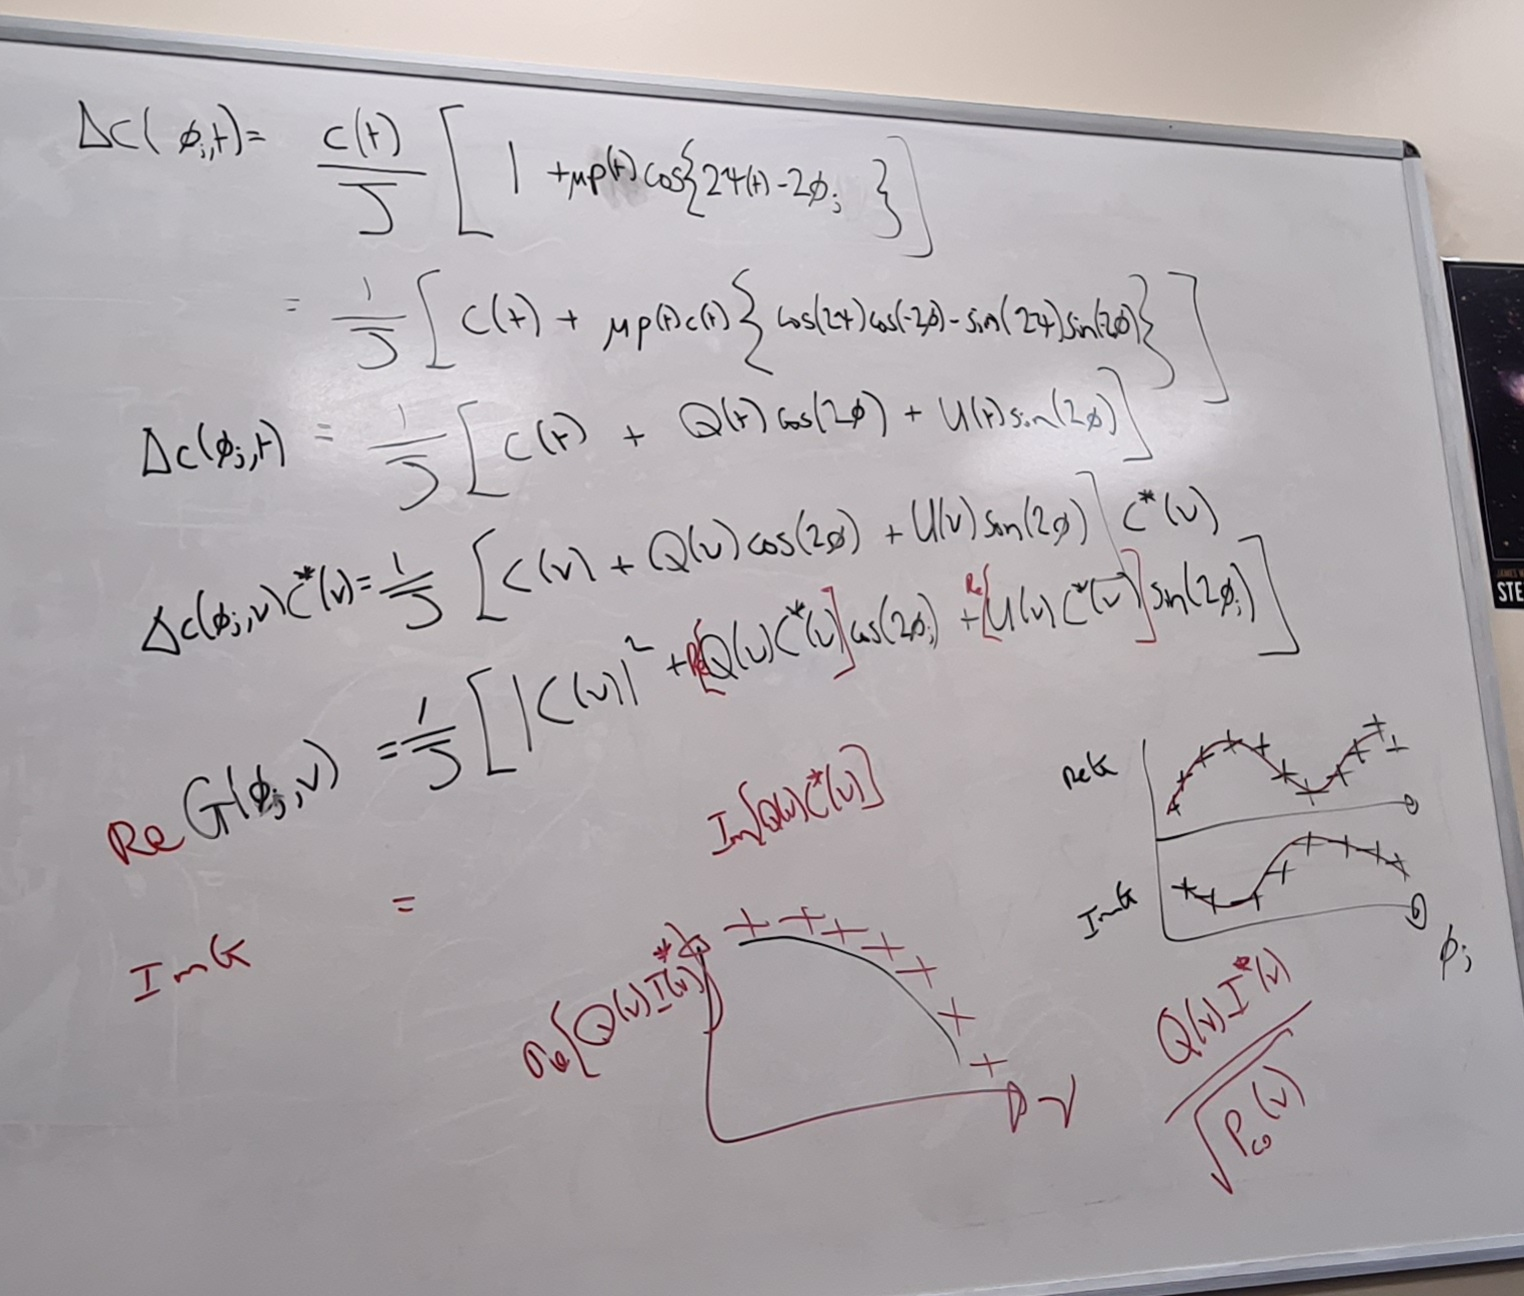

In [1]:
from IPython.display import Image
Image("/home/c2032014/cygx1_paper/20250123_112254.jpg")



### For each subject band lightcurve, we want to calculate G as usual and then fit the real and imaginary parts with a sinusoidal model. We then do this over a range of Fourier frequencies and plot the parameters of the fit as a function of fourier frequency.

What im confused about: Were fitting the real and imaginary parts seperately and so getting different values of the Q and U quantities for both. Adam then said the normalisation factor to recover Q is the sqrt of the cospec. What then does it mean for the Q to come from real and imaginary parts? How do we just recover a final q?

Adam also requested that I input a null hypothesis model.

In [2]:
import numpy as np
import sys
sys.path.append('/home/c2032014/py_files/')
import numpy as np
import load_and_clean as lac
import rms_normalisation as rn

In [3]:

from stingray import Lightcurve, Powerspectrum, AveragedCrossspectrum
import dG_span_new_abs as dgs
import G_span_abs as gs

import frac_rms_span as frmss
import phase_span as phs
import fit_rms_phase as frp
import F_test as ft
import frac_rms_err_span as fres
import phase_err_span as pes
import chi_square as chis
import importlib
importlib.reload(frp)
importlib.reload(ft)
importlib.reload(gs)
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [4]:
file1= '/home/c2032014/CYGX1/event_1pt5/ixpe01002901_det12_evt1pt5_v01_src_1.fits'
file2= '/home/c2032014/CYGX1/event_1pt5/ixpe01002901_det3_evt1pt5_v01_src.fits'
Pmin=51
Pmax=200
gti='/home/c2032014/CYGX1/event_1pt5/GTI_ixpe01002901_evt1pt5_v01_src.txt'
bin_length=1/64
seg_length=16
fmin=0
fmax=4
f_bin_number=20
mod_min=np.radians(-90)
mod_max=np.radians(90)
mod_bin_number=20
J=mod_bin_number
spur_sub=True
coherence_corrector=False
output_file= '/home/c2032014/cygx1_paper/ABC/0_4_20_ABC.npy'

In [5]:

    
#Make frequency array
fspace = np.linspace(fmin, fmax, f_bin_number + 1)
f_angle_list=[(fspace[i-1],fspace[i]) for i in range(1,len(fspace))] 
f_min_array = fspace[:-1]
f_max_array = fspace[1:]
av_f = (f_min_array + f_max_array) / 2
av_f_err = (f_max_array - f_min_array) / 2


#Make modulation angle array
aspace = np.linspace(mod_min, mod_max, mod_bin_number + 1)
mod_min_array = aspace[:-1]
mod_max_array = aspace[1:]
av_mod = (mod_min_array + mod_max_array) / 2
av_mod_err = (mod_max_array - mod_min_array) / 2


#Define sinusoidal models to fit Re[G] and Im[G] 
def cross_spec_model_real(phi,A,B,C):
    Re_G=(1/J) * ( A + (B*np.cos(2*phi)) + (C*np.sin(2*phi)) )
    return Re_G

#The imaginary sinusoid does not have the A term
def cross_spec_model_imag(phi,B,C):
    Im_G=(1/J) * ( (B*np.cos(2*phi)) + (C*np.sin(2*phi)) )
    return Im_G


    
#Loading GTI
GTI=list(np.loadtxt(str(gti)))

#Loading and cleaning data
data_1,header_1,*_=lac.load_and_clean(file1,Pmin,Pmax)
data_2,header_2,*_=lac.load_and_clean(file2,Pmin,Pmax)



#All mod bins file 1 lc
lc_1_ref=Lightcurve.make_lightcurve(data_1['TIME'],dt=bin_length,gti=GTI)
lc_1_ref.apply_gtis()

#All mod bins file 2 lc
lc_2_ref=Lightcurve.make_lightcurve(data_2['TIME'],dt=bin_length,gti=GTI)
lc_2_ref.apply_gtis()

#Required fourier products
ps_2_ref=Powerspectrum.from_lightcurve(lc_2_ref,seg_length,norm='abs')
cs_ref=AveragedCrossspectrum.from_lightcurve(lc_1_ref,lc_2_ref,seg_length,norm='abs')


num of events 9678209
num of events 4450789


In [6]:
for i in range(len(f_angle_list)):
        
        f_min=f_angle_list[i][0]
        f_max=f_angle_list[i][1]
        print(f_min,f_max)
        
        
        #print('ps_2_ref_mean',ps_2_ref_mean)

        cs_ref_real_mean=np.array(cs_ref.power.real[(f_min<=cs_ref.freq) & (cs_ref.freq<=f_max)].mean())
        cs_ref_im_mean=np.array(cs_ref.power.imag[(f_min<=cs_ref.freq) & (cs_ref.freq<=f_max)].mean()) 
        
        cs_ref_complex_mean=cs_ref_real_mean+1j*cs_ref_im_mean
        cs_ref_abs_mean=np.abs(cs_ref_complex_mean)
        #print('cs_ref_abs_mean',cs_ref_abs_mean)
        
  


0.0 0.2
0.2 0.4
0.4 0.6000000000000001
0.6000000000000001 0.8
0.8 1.0
1.0 1.2000000000000002
1.2000000000000002 1.4000000000000001
1.4000000000000001 1.6
1.6 1.8
1.8 2.0
2.0 2.2
2.2 2.4000000000000004
2.4000000000000004 2.6
2.6 2.8000000000000003
2.8000000000000003 3.0
3.0 3.2
3.2 3.4000000000000004
3.4000000000000004 3.6
3.6 3.8000000000000003
3.8000000000000003 4.0


In [7]:
from joblib import Parallel, delayed

def Q_U_NU(file1,file2,Pmin,Pmax,gti,bin_length,seg_length,fmin,fmax,
           f_bin_number,mod_min,mod_max,mod_bin_number,J,
           spur_sub,coherence_corrector,output_file):
    
    
    #Make frequency array
    fspace = np.linspace(fmin, fmax, f_bin_number + 1)
    f_angle_list=[(fspace[i-1],fspace[i]) for i in range(1,len(fspace))] 
    f_min_array = fspace[:-1]
    f_max_array = fspace[1:]
    av_f = (f_min_array + f_max_array) / 2
    av_f_err = (f_max_array - f_min_array) / 2


    #Make modulation angle array
    aspace = np.linspace(mod_min, mod_max, mod_bin_number + 1)
    mod_min_array = aspace[:-1]
    mod_max_array = aspace[1:]
    av_mod = (mod_min_array + mod_max_array) / 2
    av_mod_err = (mod_max_array - mod_min_array) / 2

    
    #Define sinusoidal models to fit Re[G] and Im[G] 
    def cross_spec_model_real(phi,A,B,C):
        Re_G=(1/J) * ( A + (B*np.cos(2*phi)) + (C*np.sin(2*phi)) )
        return Re_G

    #The imaginary sinusoid does not have the A term
    def cross_spec_model_imag(phi,B,C):
        Im_G=(1/J) * ( (B*np.cos(2*phi)) + (C*np.sin(2*phi)) )
        return Im_G
    

     
    #Loading GTI
    GTI=list(np.loadtxt(str(gti)))

    #Loading and cleaning data
    data_1,header_1,*_=lac.load_and_clean(file1,Pmin,Pmax)
    data_2,header_2,*_=lac.load_and_clean(file2,Pmin,Pmax)



    #All mod bins file 1 lc
    lc_1_ref=Lightcurve.make_lightcurve(data_1['TIME'],dt=bin_length,gti=GTI)
    lc_1_ref.apply_gtis()

    #All mod bins file 2 lc
    lc_2_ref=Lightcurve.make_lightcurve(data_2['TIME'],dt=bin_length,gti=GTI)
    lc_2_ref.apply_gtis()

    #Required fourier products
    ps_2_ref=Powerspectrum.from_lightcurve(lc_2_ref,seg_length,norm='abs')
    cs_ref=AveragedCrossspectrum.from_lightcurve(lc_1_ref,lc_2_ref,seg_length,norm='abs')



    
    #Defining stokes parameters

    I=len(data_1['TIME'])+len(data_2['TIME'])

    Q_norm=(np.sum(data_1['Q'])+np.sum(data_2['Q']))/I

    U_norm=(np.sum(data_1['U'])+np.sum(data_2['U']))/I

    
    #NULL HYPOTHESIS: If PD/PA are constant then the cross spectrum becomes:
    def cross_spec_model_null(phi,C_nu_mag_sqrd):
        ReG_null=(1/J) *C_nu_mag_sqrd* (1 + Q_norm*np.cos(2*phi) + U_norm*np.sin(2*phi))
        return ReG_null

    #so the real part is some constant M*C_nu_mag_sqrd and the im part is 0

    #Define arrays to store results
    A_real=[]
    B_real=[]
    C_real=[]

    A_real_err_arr=[]
    B_real_err_arr=[]
    C_real_err_arr=[]

    B_imag_err_arr=[]
    C_imag_err_arr=[]

    B_imag=[]
    C_imag=[]

    G_null_real_arr=[]
    G_null_imag_arr=[]

    A_null_real_arr=[]
    B_null_real_arr=[]
    C_null_real_arr=[]

    #A_null_real_err_arr=[]
    #B_null_real_err_arr=[]
    #C_null_real_err_arr=[]

    B_null_imag_arr=[]
    C_null_imag_arr=[]

    #Iterating over each frequency bin

    for i in range(len(f_angle_list)):
        
        f_min=f_angle_list[i][0]
        f_max=f_angle_list[i][1]
        print(f_min,f_max)
        
        ps_2_ref_mean=ps_2_ref.power[(f_min<=ps_2_ref.freq) & (ps_2_ref.freq<=f_max)].mean()
        #print('ps_2_ref_mean',ps_2_ref_mean)

        cs_ref_real_mean=np.array(cs_ref.power.real[(f_min<=cs_ref.freq) & (cs_ref.freq<=f_max)].mean())
        cs_ref_im_mean=np.array(cs_ref.power.imag[(f_min<=cs_ref.freq) & (cs_ref.freq<=f_max)].mean()) 
        
        cs_ref_complex_mean=cs_ref_real_mean+1j*cs_ref_im_mean
        cs_ref_abs_mean=np.abs(cs_ref_complex_mean)
        #print('cs_ref_abs_mean',cs_ref_abs_mean)
        
  

        #print('cs_ref_real_mean ie A:',cs_ref_real_mean) #same as A within errors


        norm_factor=np.sqrt(cs_ref.power.real[(f_min<=cs_ref.freq) & (cs_ref.freq<=f_max)].mean())
        
        norm='abs'
       
        
        #Calculate G and dG
        G_real_span, G_im_span, n_span, m_span,lc_1_sub_span, *_=gs.G_span(mod_bin_number,data_1,lc_2_ref,GTI,bin_length,seg_length,f_min,f_max,spur_sub,norm)
    

        dG_span= dgs.dG_span(G_real_span,G_im_span,lc_1_sub_span,n_span,
                m_span,f_min,f_max,seg_length,
                ps_2_ref_mean,cs_ref_real_mean,coherence_corrector,norm)
        
        #Fit real and im parts of G
        parameters_real,pcovreal=curve_fit(cross_spec_model_real,np.array(av_mod),np.array(G_real_span))
        A_real.append(parameters_real[0])
        print('A',parameters_real[0])
        B_real.append(parameters_real[1])
        C_real.append(parameters_real[2])
        fit_real = cross_spec_model_real(np.array(av_mod),parameters_real[0],parameters_real[1],parameters_real[2])

        parameters_imag,pcovimag=curve_fit(cross_spec_model_imag,np.array(av_mod),np.array(G_im_span))
        B_imag.append(parameters_imag[0])
        C_imag.append(parameters_imag[1])
        fit_imag = cross_spec_model_imag(np.array(av_mod),parameters_imag[0],parameters_imag[1])

        Areal_err,Breal_err,Creal_err= np.sqrt(np.diag(pcovreal))
        A_real_err_arr.append(Areal_err)
        B_real_err_arr.append(Breal_err)
        C_real_err_arr.append(Creal_err)
        Bimag_err,Cimag_err= np.sqrt(np.diag(pcovimag))
        B_imag_err_arr.append(Bimag_err)
        C_imag_err_arr.append(Cimag_err)


        G_null=cross_spec_model_null(np.array(av_mod),cs_ref_abs_mean)
        
        G_null_real=G_null.real
        #print('G_null_real',G_null_real)
        #G_null_real_arr.append(G_null_real)
        G_null_imag=G_null.imag

        A_null_real=cs_ref_abs_mean
        B_null_real=cs_ref_abs_mean*Q_norm
        C_null_real=cs_ref_abs_mean*U_norm

        A_null_real_arr.append(A_null_real)
        B_null_real_arr.append(B_null_real)
        C_null_real_arr.append(C_null_real)
        B_null_imag=0
        C_null_imag=0
        B_null_imag_arr.append(B_null_imag)
        C_null_imag_arr.append(C_null_imag)

        

#        print('PLotting...')
        plt.figure()
        plt.title('Real')
        plt.errorbar(av_mod,G_real_span,xerr=av_mod_err,yerr=dG_span,ls='None',label='Real')
        plt.plot(av_mod,G_null_real,label='Null')
        plt.plot(av_mod,fit_real,label='fit')
        plt.legend()
        plt.show()
        plt.figure()
        plt.title('Imaginary')
        plt.errorbar(av_mod,G_im_span,xerr=av_mod_err,yerr=np.array(dG_span)/(2*np.pi),ls='None',label='Imaginary')
        plt.plot(av_mod,fit_imag,label='fit')
        plt.plot(av_mod,G_null_imag,label='Null')
        plt.legend()
        plt.show()


    #Plot results

    #plt.figure()
    #plt.title('Re[G] (null)')
    #plt.ylabel('Re[G] (null)')
    #plt.plot(av_f,G_null_real_arr,'.')
    #plt.xlabel('Frequency (Hz)')
    #plt.xscale('log')
    #plt.yscale('log')
    #plt.show()

    plt.figure()
    plt.title('Real')
    plt.errorbar(av_f,A_real,xerr=av_f_err,yerr=Areal_err,ls='None',label='A')
    plt.plot(av_f,A_real,label='A')
    plt.legend()
    plt.figure()
    plt.title('Real')
    plt.plot(av_f,B_real,label='B')
    plt.errorbar(av_f,B_real,xerr=av_f_err,yerr=B_real_err_arr,ls='None',label='B')
    plt.plot(av_f,C_real,label='C')
    plt.errorbar(av_f,C_real,xerr=av_f_err,yerr=C_real_err_arr,ls='None',label='C')
    plt.legend()

    plt.figure()
    plt.title('Imaginary')
    plt.plot(av_f,B_imag,label='B')
    plt.errorbar(av_f,B_imag,xerr=av_f_err,yerr=B_imag_err_arr,ls='None',label='B')
    plt.plot(av_f,C_imag,label='C')
    plt.errorbar(av_f,C_imag,xerr=av_f_err,yerr=C_imag_err_arr,ls='None',label='C')
    plt.legend()
    print(A_real,A_real_err_arr,B_real,B_real_err_arr,C_real,C_real_err_arr,B_imag,B_imag_err_arr,C_imag,C_imag_err_arr,av_f,av_f_err,A_null_real_arr,B_null_real_arr,C_null_real_arr,B_null_imag_arr,C_null_imag_arr)
    results=np.array(tuple(zip(A_real,A_real_err_arr,B_real,B_real_err_arr,C_real,C_real_err_arr,B_imag,B_imag_err_arr,C_imag,C_imag_err_arr,av_f,av_f_err,A_null_real_arr,B_null_real_arr,C_null_real_arr,B_null_imag_arr,C_null_imag_arr)))
    np.save(output_file,results)
    return results

In [8]:
# A_real,B_real,C_real,B_imag,C_imag, av_f,norm_factor=
A_real,A_real_err_arr,B_real,B_real_err_arr,C_real,C_real_err_arr,B_imag,B_imag_err_arr,C_imag,C_imag_err_arr,av_f,av_f_err,A_null_real_arr,B_null_real_arr,C_null_real_arr,B_null_imag_arr,C_null_imag_arr=Q_U_NU(file1,file2,Pmin,Pmax,gti,bin_length,seg_length,fmin,fmax,
           f_bin_number,mod_min,mod_max,mod_bin_number,J,
           spur_sub,coherence_corrector,output_file)

num of events 9678209
num of events 4450789
0.0 0.2


TypeError: dG_span() takes 11 positional arguments but 12 were given

In [4]:
result=np.load(output_file)
result=np.transpose(result)
A_real,A_real_err_arr,B_real,B_real_err_arr,C_real,C_real_err_arr,B_imag,B_imag_err_arr,C_imag,C_imag_err_arr,av_f,av_f_err,A_null_real_arr,B_null_real_arr,C_null_real_arr,B_null_imag_arr,C_null_imag_arr=result

# Using the outputs of the last run to hopefully fix everything

In [5]:
print('A_real',type(A_real))
print(type(av_f))
print(type(av_f_err))
print('A_real_err_arr',type(A_real_err_arr))


A_real <class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
A_real_err_arr <class 'numpy.ndarray'>


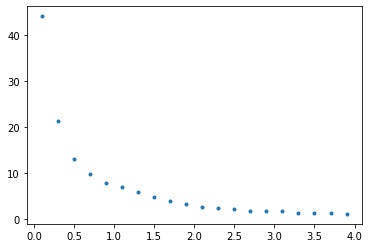

In [6]:
plt.figure()
plt.plot(av_f,A_real,'.')
#plt.errorbar(av_f,A_real,xerr=av_f_err,yerr=A_real_err_arr,ls='None',label='A')

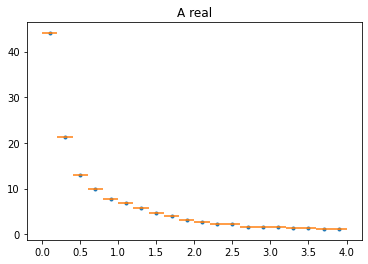

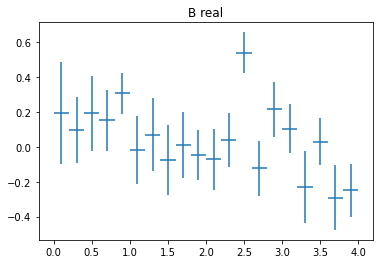

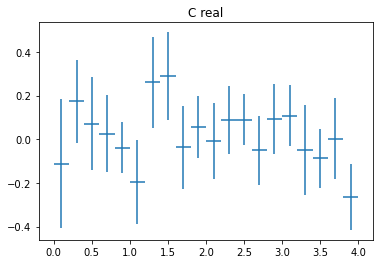

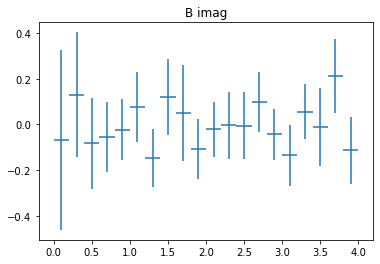

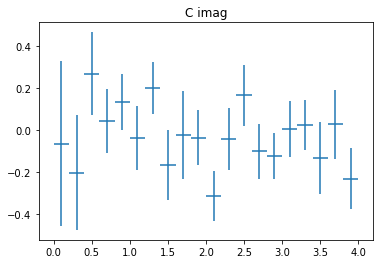

In [7]:
import matplotlib.pyplot as plt
plt.figure()
plt.title('A real')
plt.plot(av_f,A_real,'.') 
plt.errorbar(av_f,A_real,xerr=av_f_err,yerr=A_real_err_arr,ls='None')
#plt.plot(cs_ref.freq,cs_ref.power.real,'.')
#plt.xscale('log')
#plt.yscale('log')
#plt.show()

plt.figure()
plt.title('B real')
#plt.plot(av_f,B_real,'.')
plt.errorbar(av_f,B_real,xerr=av_f_err,yerr=B_real_err_arr,ls='None')
#plt.xscale('log')
#plt.yscale('log')
plt.show()

plt.figure()
plt.title('C real')
#plt.plot(av_f,C_real,'.')
plt.errorbar(av_f,C_real,xerr=av_f_err,yerr=C_real_err_arr,ls='None')
#plt.xscale('log')
#plt.yscale('log')
plt.show()


plt.figure()
plt.title('B imag')
#plt.plot(av_f,B_imag,'.')
plt.errorbar(av_f,B_imag,xerr=av_f_err,yerr=B_imag_err_arr,ls='None')
#plt.xscale('log')
#plt.yscale('log')
plt.show()

plt.figure()
plt.title('C imag')
#plt.plot(av_f,C_imag,'.')
plt.errorbar(av_f,C_imag,xerr=av_f_err,yerr=C_imag_err_arr,ls='None')
#plt.xscale('log')
#plt.yscale('log')
plt.show()





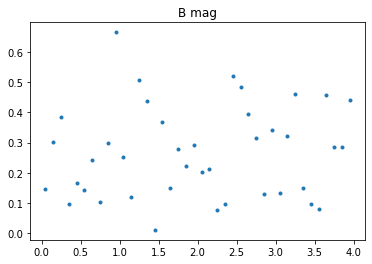

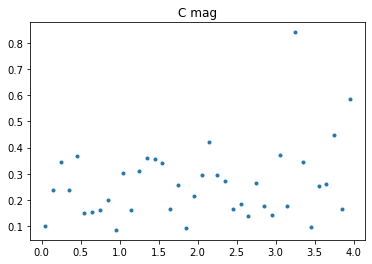

In [25]:
b=B_real+1j*B_imag
b_mag=np.abs(b)
plt.figure()
plt.title('B mag')
plt.plot(av_f,b_mag,'.')

c=C_real+1j*C_imag
c_mag=np.abs(c)
plt.figure()
plt.title('C mag')
plt.plot(av_f,c_mag,'.')


In [12]:
print(A_real_err_arr)

[0.20753431 0.133467   0.15143322 0.1240377  0.08233051 0.13602045
 0.14687842 0.14209875 0.13474894 0.09995327 0.12227736 0.11014824
 0.08324279 0.11118176 0.1127654  0.09832529 0.14631306 0.09515
 0.13083107 0.10733757]


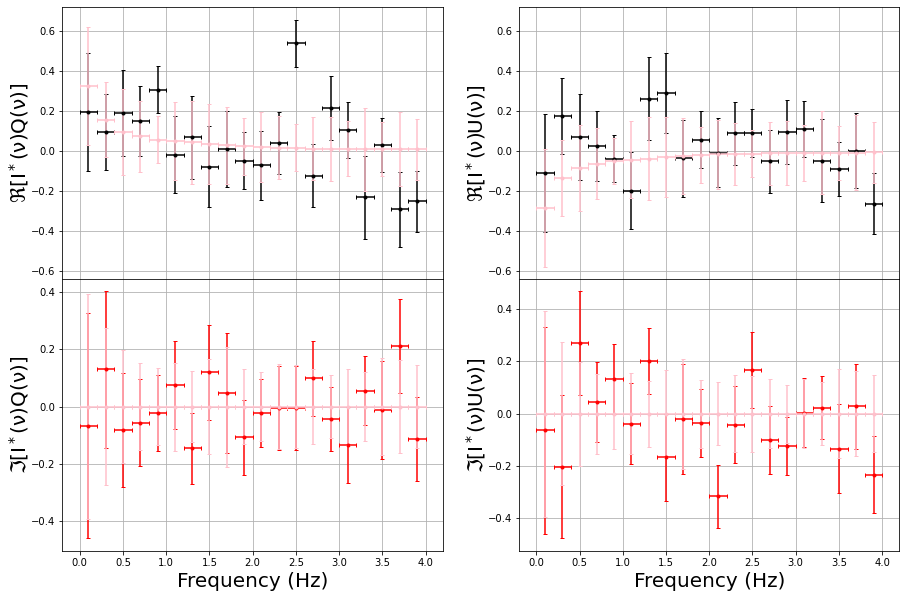

In [128]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 10))
#plt.plot(av_f, A_real, '.', label='A real')
# Create a GridSpec with 2 rows (we removed the top plot)
outer_gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])  # Middle and bottom plots get more space
outer_gs.update(hspace=0)

# B real and C real
middle_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_gs[0])
ax_b_real = fig.add_subplot(middle_gs[0])
ax_c_real = fig.add_subplot(middle_gs[1], sharey=ax_b_real)
ax_b_real.set_ylabel(r'$\Re[\rm I^*(\nu) \rm Q(\nu)]$', size=20, labelpad=0)
ax_c_real.set_ylabel(r'$\Re[\rm I^*(\nu) \rm U(\nu)]$', size=20, labelpad=0)
#ax_c_real.set_title('C real')
ax_b_real.errorbar(av_f, B_real, xerr=av_f_err, yerr=B_real_err_arr, ls='None', fmt='.', capsize=2,color='black')
ax_b_real.errorbar(av_f,B_null_real_arr,xerr=av_f_err,yerr=B_real_err_arr,ls='None',fmt='.',capsize=2,color='pink')
ax_c_real.errorbar(av_f, C_real, xerr=av_f_err, yerr=C_real_err_arr, ls='None', fmt='.', capsize=2,color='black')
ax_c_real.errorbar(av_f,C_null_real_arr,xerr=av_f_err,yerr=C_real_err_arr,ls='None',fmt='.',capsize=2,color='pink')
ax_b_real.grid(True)
ax_c_real.grid(True)

# B imag and C imag (shares x-axis with the above)
bottom_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_gs[1])
ax_b_imag = fig.add_subplot(bottom_gs[0], sharex=ax_b_real)  # B imag shares x-axis with B real
ax_c_imag = fig.add_subplot(bottom_gs[1], sharex=ax_b_real)  # C imag shares x-axis with B real
ax_b_imag.set_ylabel(r'$\Im[\rm I^*(\nu) \rm Q(\nu)]$', size=20, labelpad=0)
ax_c_imag.set_ylabel(r'$\Im[\rm I^*(\nu) \rm U(\nu)]$', size=20, labelpad=0)
ax_b_imag.errorbar(av_f, B_imag, xerr=av_f_err, yerr=B_imag_err_arr, ls='None', fmt='.', capsize=2,color='red')
ax_b_imag.errorbar(av_f,B_null_imag_arr,xerr=av_f_err,yerr=B_imag_err_arr,ls='None',fmt='.',capsize=2,color='pink')
ax_c_imag.errorbar(av_f, C_imag, xerr=av_f_err, yerr=C_imag_err_arr, ls='None', fmt='.', capsize=2,color='red')
ax_c_imag.errorbar(av_f,C_null_imag_arr,xerr=av_f_err,yerr=C_imag_err_arr,ls='None',fmt='.',capsize=2,color='pink')
ax_c_imag.set_xlabel('Frequency (Hz)', fontsize=20)
ax_b_imag.set_xlabel('Frequency (Hz)', fontsize=20)
ax_b_imag.grid(True)
ax_c_imag.grid(True)



# Tight layout to avoid overlap of labels
#plt.tight_layout(rect=[0.06, 0.04, 1, 0.95])
plt.savefig('B_C_real_imag_wnull.pdf',dpi=1000)
plt.show()


In [1]:
plt.figure(figsize=(7, 5))
#plt.plot(av_f,A_real,'.')
plt.errorbar(av_f,A_real,xerr=av_f_err,yerr=A_real_err_arr,ls='None',color='black',capsize=2)
plt.errorbar(av_f,A_null_real_arr,xerr=av_f_err,yerr=A_real_err_arr,ls='None',color='pink',capsize=10)
plt.plot(cs_ref.freq,cs_ref.power,'.')
plt.errorbar(av_f,A_real,xerr=av_f_err,yerr=A_real_err_arr,ls='None',color='black',capsize=2)
plt.xscale('log')
plt.yscale('log')
#plt.title('A real')
plt.xlabel('Frequency (Hz)',size=20)
plt.ylabel(r'$|I(\nu)|^2$',size=20,labelpad=0)
#plt.grid(True)
plt.savefig('A_real_test.pdf',dpi=1000)

NameError: name 'plt' is not defined

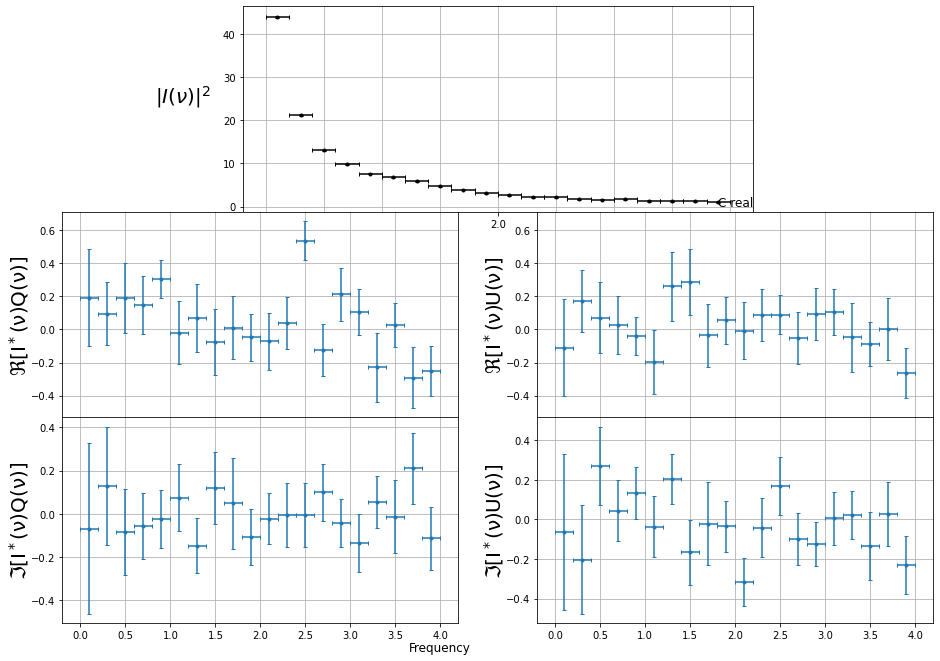

In [85]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 10))
outer_gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])  # 3 rows
#outer_gs.update(hspace=0)

# A real (centered and slightly wider)
top_gs = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=outer_gs[0])
ax_a_real = fig.add_subplot(top_gs[1:4])  # Spans middle 3 of 5 columns
ax_a_real.set_ylabel(r'$|I(\nu)|^2$', size=20, rotation=0, labelpad=40)
ax_a_real.errorbar(av_f, A_real, xerr=av_f_err, yerr=A_real_err_arr, ls='None', fmt='.', capsize=2, color='black')
ax_a_real.grid(True)

# B real and C real (now swapping B imag and C real)
middle_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_gs[1])
ax_b_real = fig.add_subplot(middle_gs[0])
ax_c_real = fig.add_subplot(middle_gs[1], sharey=ax_b_real)
ax_b_real.set_ylabel(r'$\Re[\rm I^*(\nu) \rm Q(\nu)]$', size=20, labelpad=0)
ax_c_real.set_ylabel(r'$\Re[\rm I^*(\nu) \rm U(\nu)]$', size=20, labelpad=0)
ax_c_real.set_title('C real')
ax_b_real.errorbar(av_f, B_real, xerr=av_f_err, yerr=B_real_err_arr, ls='None', fmt='.', capsize=2)
ax_c_real.errorbar(av_f, C_real, xerr=av_f_err, yerr=C_real_err_arr, ls='None', fmt='.', capsize=2)
ax_b_real.grid(True)
ax_c_real.grid(True)
outer_gs.update(hspace=0)
# B imag and C imag (swap B imag and C real)
bottom_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_gs[2])
ax_b_imag = fig.add_subplot(bottom_gs[0], sharex=ax_b_real)  # B imag shares x-axis with B real
ax_c_imag = fig.add_subplot(bottom_gs[1], sharex=ax_b_real)  # C imag shares x-axis with B real
ax_b_imag.set_ylabel(r'$\Im[\rm I^*(\nu) \rm Q(\nu)]$', size=20, labelpad=0)
ax_c_imag.set_ylabel(r'$\Im[\rm I^*(\nu) \rm U(\nu)]$', size=20, labelpad=0)
ax_b_imag.errorbar(av_f, B_imag, xerr=av_f_err, yerr=B_imag_err_arr, ls='None', fmt='.', capsize=2)
ax_c_imag.errorbar(av_f, C_imag, xerr=av_f_err, yerr=C_imag_err_arr, ls='None', fmt='.', capsize=2)
ax_b_imag.grid(True)
ax_c_imag.grid(True)

# Global labels
fig.text(0.5, 0.04, 'Frequency', ha='center', fontsize=12)
#ax_grid=ax_b_real.subplots(sharex=True)
# Adjust layout to remove space between shared x-axis plots


# Tight layout to avoid overlap of labels
plt.tight_layout(rect=[0.06, 0.04, 1, 0.95])

plt.show()


Writing the above function stacking observations

In [7]:
from joblib import Parallel, delayed

def Q_U_NU_stack(file1_obs1,file2_obs1,
                 file1_obs2,file2_obs2
                 ,Pmin,Pmax,gti_obs1,gti_obs2,bin_length,seg_length,fmin,fmax,
           f_bin_number,mod_min,mod_max,mod_bin_number,J,
           spur_sub,coherence_corrector,output_file,stack=True):
    
    
    #Make frequency array
    fspace = np.linspace(fmin, fmax, f_bin_number + 1)
    f_angle_list=[(fspace[i-1],fspace[i]) for i in range(1,len(fspace))] 
    f_min_array = fspace[:-1]
    f_max_array = fspace[1:]
    av_f = (f_min_array + f_max_array) / 2
    av_f_err = (f_max_array - f_min_array) / 2


    #Make modulation angle array
    aspace = np.linspace(mod_min, mod_max, mod_bin_number + 1)
    mod_min_array = aspace[:-1]
    mod_max_array = aspace[1:]
    av_mod = (mod_min_array + mod_max_array) / 2
    av_mod_err = (mod_max_array - mod_min_array) / 2

    
    #Define sinusoidal models to fit Re[G] and Im[G] 
    def cross_spec_model_real(phi,A,B,C):
        Re_G=(1/J) * ( A + (B*np.cos(2*phi)) + (C*np.sin(2*phi)) )
        return Re_G

    #The imaginary sinusoid does not have the A term
    def cross_spec_model_imag(phi,B,C):
        Im_G=(1/J) * ( (B*np.cos(2*phi)) + (C*np.sin(2*phi)) )
        return Im_G
    

     
    #Loading GTI
    GTI_obs1=list(np.loadtxt(str(gti_obs1)))
    GTI_obs2=list(np.loadtxt(str(gti_obs2)))

    #Loading and cleaning data
    data_1_obs1,header_1_obs1,*_=lac.load_and_clean(file1_obs1,Pmin,Pmax)
    data_2_obs1,header_2_obs1,*_=lac.load_and_clean(file2_obs1,Pmin,Pmax)

    data_1_obs2,header_1_obs2,*_=lac.load_and_clean(file1_obs2,Pmin,Pmax)
    data_2_obs2,header_2_obs2,*_=lac.load_and_clean(file2_obs2,Pmin,Pmax)



    #All mod bins file 1 lc
    lc_1_ref_obs1=Lightcurve.make_lightcurve(data_1_obs1['TIME'],dt=bin_length,gti=GTI_obs1)
    lc_1_ref_obs1.apply_gtis()

    #All mod bins file 2 lc
    lc_2_ref_obs1=Lightcurve.make_lightcurve(data_2_obs1['TIME'],dt=bin_length,gti=GTI_obs1)
    lc_2_ref_obs1.apply_gtis()

    #Required fourier products
    ps_2_ref_obs1=Powerspectrum.from_lightcurve(lc_2_ref_obs1,seg_length,norm='abs')
    cs_ref_obs1=AveragedCrossspectrum.from_lightcurve(lc_1_ref_obs1,lc_2_ref_obs1,seg_length,norm='abs')

    lc_1_ref_obs2=Lightcurve.make_lightcurve(data_1_obs2['TIME'],dt=bin_length,gti=GTI_obs2)
    lc_1_ref_obs2.apply_gtis()

    lc_2_ref_obs2=Lightcurve.make_lightcurve(data_2_obs2['TIME'],dt=bin_length,gti=GTI_obs2)
    lc_2_ref_obs2.apply_gtis()

    ps_2_ref_obs2=Powerspectrum.from_lightcurve(lc_2_ref_obs2,seg_length,norm='abs')
    cs_ref_obs2=AveragedCrossspectrum.from_lightcurve(lc_1_ref_obs2,lc_2_ref_obs2,seg_length,norm='abs')


    
    #Defining stokes parameters

    I=len(data_1_obs1['TIME'])+len(data_2_obs1['TIME'])+len(data_1_obs2['TIME'])+len(data_2_obs2['TIME'])

    Q_norm=(np.sum(data_1_obs1['Q'])+np.sum(data_2_obs1['Q'])+np.sum(data_1_obs2['Q'])+np.sum(data_2_obs2['Q']))/I

    U_norm=(np.sum(data_1_obs1['U'])+np.sum(data_2_obs1['U'])+np.sum(data_1_obs2['U'])+np.sum(data_1_obs2['U']))/I

    
    #NULL HYPOTHESIS: If PD/PA are constant then the cross spectrum becomes:
    def cross_spec_model_null(phi,C_nu_mag_sqrd):
        ReG_null=(1/J) *C_nu_mag_sqrd* (1 + Q_norm*np.cos(2*phi) + U_norm*np.sin(2*phi))
        return ReG_null

    #so the real part is some constant M*C_nu_mag_sqrd and the im part is 0

    #Define arrays to store results
    A_real=[]
    B_real=[]
    C_real=[]

    A_real_err_arr=[]
    B_real_err_arr=[]
    C_real_err_arr=[]

    B_imag_err_arr=[]
    C_imag_err_arr=[]

    B_imag=[]
    C_imag=[]

    G_null_real_arr=[]
    G_null_imag_arr=[]

    A_null_real_arr=[]
    B_null_real_arr=[]
    C_null_real_arr=[]

    #A_null_real_err_arr=[]
    #B_null_real_err_arr=[]
    #C_null_real_err_arr=[]

    B_null_imag_arr=[]
    C_null_imag_arr=[]

    #Iterating over each frequency bin

    for i in range(len(f_angle_list)):
        
        f_min=f_angle_list[i][0]
        f_max=f_angle_list[i][1]
        print(f_min,f_max)
        
        ps_2_ref_mean_obs1=ps_2_ref_obs1.power[(f_min<=ps_2_ref_obs1.freq) & (ps_2_ref_obs1.freq<=f_max)].mean()
        ps_2_ref_mean_obs2=ps_2_ref_obs2.power[(f_min<=ps_2_ref_obs2.freq) & (ps_2_ref_obs2.freq<=f_max)].mean()

        print('ps_2_ref_mean calculated')

        cs_ref_real_mean_obs1=np.array(cs_ref_obs1.power.real[(f_min<=cs_ref_obs1.freq) & (cs_ref_obs1.freq<=f_max)].mean())
        cs_ref_im_mean_obs1=np.array(cs_ref_obs1.power.imag[(f_min<=cs_ref_obs1.freq) & (cs_ref_obs1.freq<=f_max)].mean())

        cs_ref_real_mean_obs2=np.array(cs_ref_obs2.power.real[(f_min<=cs_ref_obs2.freq) & (cs_ref_obs2.freq<=f_max)].mean())  #same as A within errors
        cs_ref_im_mean_obs2=np.array(cs_ref_obs2.power.imag[(f_min<=cs_ref_obs2.freq) & (cs_ref_obs2.freq<=f_max)].mean())

        print('cs_ref_real_mean calculated')

        #stacking cs_ref_mean_obs1 and cs_ref_mean_obs2

        cs_ref_real_mean_stack=((cs_ref_obs1.m*cs_ref_real_mean_obs1)+(cs_ref_obs2.m*cs_ref_real_mean_obs2))/(cs_ref_obs1.m+cs_ref_obs2.m)
        cs_ref_im_mean_stack=((cs_ref_obs1.m*cs_ref_im_mean_obs1)+(cs_ref_obs2.m*cs_ref_im_mean_obs2))/(cs_ref_obs1.m+cs_ref_obs2.m)



        cs_ref_complex_mean_stack=cs_ref_real_mean_stack+1j*cs_ref_im_mean_stack
        cs_ref_abs_mean_stack=np.abs(cs_ref_complex_mean_stack)

        print('cs_ref_abs_mean stack calculated')

        #stacking ps2 _ref_mean_obs1 and ps2_ref_mean_obs2

        ps_2_ref_mean_stack=((ps_2_ref_obs1.m*ps_2_ref_mean_obs1)+(ps_2_ref_obs2*ps_2_ref_mean_obs2))/(ps_2_ref_obs1.m+ps_2_ref_obs2.m)
        
        print('ps_2_ref_mean_stack calculated')

        #cs_ref_complex_mean_obs1=cs_ref_real_mean_obs1+1j*cs_ref_im_mean_obs1
        #cs_ref_abs_mean_obs1=np.abs(cs_ref_complex_mean_obs1)
        
        #cs_ref_complex_mean_obs2=cs_ref_real_mean_obs2+1j*cs_ref_im_mean_obs2
        #cs_ref_abs_mean_obs2=np.abs(cs_ref_complex_mean_obs2)


        

        norm='abs'
        
        #Calculate G and dG
        
        G_real_span_obs1, G_im_span_obs1, n_span_obs1, m_span_obs1,lc_1_sub_span_obs1, *_=gs.G_span(mod_bin_number,data_1_obs1,lc_2_ref_obs1,GTI_obs1,bin_length,seg_length,f_min,f_max,spur_sub,norm)
        print('G_span_obs1 calculated')
        G_real_span_obs2, G_im_span_obs2, n_span_obs2, m_span_obs2,lc_1_sub_span_obs2, *_=gs.G_span(mod_bin_number,data_1_obs2,lc_2_ref_obs2,GTI_obs2,bin_length,seg_length,f_min,f_max,spur_sub,norm)
        print('G_span_obs2 calculated')

        #Calulating an average G weighted on the number of segments m

        G_real_span_stack=(m_span_obs1*G_real_span_obs1+m_span_obs2*G_real_span_obs2)/(m_span_obs1+m_span_obs2)
        G_im_span_stack=(m_span_obs1*G_im_span_obs1+m_span_obs2*G_im_span_obs2)/(m_span_obs1+m_span_obs2)

        
       
        
        
        dG_span_stack= dgs.dG_span(G_real_span_stack,G_im_span_stack,lc_1_sub_span_obs1,n_span_obs1,
                m_span_obs1,f_min,f_max,seg_length,
                ps_2_ref_mean_stack,cs_ref_real_mean_stack,coherence_corrector,norm,stack,lc_1_sub_span_obs2,
                n_span_obs1,n_span_obs2,m_span_obs1,m_span_obs2)
        
        
        #Now to stack 

        #Fit real and im parts of G
        parameters_real,pcovreal=curve_fit(cross_spec_model_real,np.array(av_mod),np.array(G_real_span_stack))
        A_real.append(parameters_real[0])
        print('A',parameters_real[0])
        B_real.append(parameters_real[1])
        C_real.append(parameters_real[2])
        fit_real = cross_spec_model_real(np.array(av_mod),parameters_real[0],parameters_real[1],parameters_real[2])

        parameters_imag,pcovimag=curve_fit(cross_spec_model_imag,np.array(av_mod),np.array(G_im_span_stack))
        B_imag.append(parameters_imag[0])
        C_imag.append(parameters_imag[1])
        fit_imag = cross_spec_model_imag(np.array(av_mod),parameters_imag[0],parameters_imag[1])

        Areal_err,Breal_err,Creal_err= np.sqrt(np.diag(pcovreal))
        A_real_err_arr.append(Areal_err)
        B_real_err_arr.append(Breal_err)
        C_real_err_arr.append(Creal_err)
        Bimag_err,Cimag_err= np.sqrt(np.diag(pcovimag))
        B_imag_err_arr.append(Bimag_err)
        C_imag_err_arr.append(Cimag_err)


        G_null=cross_spec_model_null(np.array(av_mod),cs_ref_abs_mean_stack)
        
        G_null_real=G_null.real
        #print('G_null_real',G_null_real)
        #G_null_real_arr.append(G_null_real)
        G_null_imag=G_null.imag

        A_null_real=cs_ref_abs_mean_stack
        B_null_real=cs_ref_abs_mean_stack*Q_norm
        C_null_real=cs_ref_abs_mean_stack*U_norm

        A_null_real_arr.append(A_null_real)
        B_null_real_arr.append(B_null_real)
        C_null_real_arr.append(C_null_real)
        B_null_imag=0
        C_null_imag=0
        B_null_imag_arr.append(B_null_imag)
        plt.errorbar(av_mod,G_im_span,xerr=av_mod_err,yerr=np.array(dG_span)/(2*np.pi),ls='None',label='Imaginary')
        plt.plot(av_mod,fit_imag,label='fit')
        plt.plot(av_mod,G_null_imag,label='Null')
        plt.legend()
        plt.show()


    #Plot results

    #plt.figure()
    #plt.title('Re[G] (null)')
    #plt.ylabel('Re[G] (null)')
    #plt.plot(av_f,G_null_real_arr,'.')
    #plt.xlabel('Frequency (Hz)')
    #plt.xscale('log')
    #plt.yscale('log')
    #plt.show()

    plt.figure()
    plt.title('Real')
    plt.errorbar(av_f,A_real,xerr=av_f_err,yerr=Areal_err,ls='None',label='A')
    plt.plot(av_f,A_real,label='A')
    plt.legend()
    plt.figure()
    plt.title('Real')
    plt.plot(av_f,B_real,label='B')
    plt.errorbar(av_f,B_real,xerr=av_f_err,yerr=B_real_err_arr,ls='None',label='B')
    plt.plot(av_f,C_real,label='C')
    plt.errorbar(av_f,C_real,xerr=av_f_err,yerr=C_real_err_arr,ls='None',label='C')
    plt.legend()

    plt.figure()
    plt.title('Imaginary')
    plt.plot(av_f,B_imag,label='B')
    plt.errorbar(av_f,B_imag,xerr=av_f_err,yerr=B_imag_err_arr,ls='None',label='B')
    plt.plot(av_f,C_imag,label='C')
    plt.errorbar(av_f,C_imag,xerr=av_f_err,yerr=C_imag_err_arr,ls='None',label='C')
    plt.legend()
    print(A_real,A_real_err_arr,B_real,B_real_err_arr,C_real,C_real_err_arr,B_imag,B_imag_err_arr,C_imag,C_imag_err_arr,av_f,av_f_err,A_null_real_arr,B_null_real_arr,C_null_real_arr,B_null_imag_arr,C_null_imag_arr)
    results=np.array(tuple(zip(A_real,A_real_err_arr,B_real,B_real_err_arr,C_real,C_real_err_arr,B_imag,B_imag_err_arr,C_imag,C_imag_err_arr,av_f,av_f_err,A_null_real_arr,B_null_real_arr,C_null_real_arr,B_null_imag_arr,C_null_imag_arr)))
    np.save(output_file,results)
    return results



In [3]:
file1_obs1= '/home/c2032014/CYGX1/event_1pt5/ixpe01002901_det12_evt1pt5_v01_src_1.fits'
file2_obs1= '/home/c2032014/CYGX1/event_1pt5/ixpe01002901_det3_evt1pt5_v01_src.fits'
file1_obs2='/home/c2032014/cyg_june/CYGX1_JUNE/event_1pt5/ixpe01250101_det12_evt1pt5_v01_src.fits'
file2_obs2='/home/c2032014/cyg_june/CYGX1_JUNE/event_1pt5/ixpe01250101_det3_evt1pt5_v01_src.fits'
Pmin=51
Pmax=200
gti_obs1='/home/c2032014/CYGX1/event_1pt5/GTI_ixpe01002901_evt1pt5_v01_src.txt'
gti_obs2='/home/c2032014/cyg_june/CYGX1_JUNE/event_1pt5/GTI_ixpe01250101_evt1pt5_v01_src.txt'
bin_length=1/64
seg_length=16
fmin=0
fmax=4
f_bin_number=2
mod_min=np.radians(-90)
mod_max=np.radians(90)
mod_bin_number=20
J=mod_bin_number
spur_sub=True
coherence_corrector=False
output_file= '/home/c2032014/cygx1_paper/ABC/stack_test.npy'

In [8]:
Q_U_NU_stack(file1_obs1,file2_obs1,
                 file1_obs2,file2_obs2
                 ,Pmin,Pmax,gti_obs1,gti_obs2,bin_length,seg_length,fmin,fmax,
                 f_bin_number,mod_min,mod_max,mod_bin_number,J,
                 spur_sub,coherence_corrector,output_file,stack=True)

num of events 9678209
num of events 4450789
num of events 3964407
num of events 1845919
0.0 2.0
ps_2_ref_mean calculated
cs_ref_real_mean calculated
cs_ref_abs_mean stack calculated
